## Generate tables and figures for the paper

In [132]:
import os
import pandas as pd
import json


output_dir = "../output"
assert os.path.exists(output_dir)


def read_results(results_path: os.PathLike) -> pd.DataFrame:
    """
    Read the results from the results path.

    Example of results path:
    ```
    output/randomized_greedy/instances_generic/20250722_115309/
    ```
    """
    # list all subdirectories in results_path, which are the instances
    instances = os.listdir(results_path)
    # for every file in an instance, read it and concatenate them
    df = pd.DataFrame()
    for instance in instances:
        configurations = os.listdir(os.path.join(results_path, instance))
        for configuration in configurations:
            file = os.path.join(results_path, instance, configuration)
            # read lines of file, which can be json-decoded, use readlines
            with open(file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    json_line = json.loads(line)
                    # append to dataframe
                    df = pd.concat([df, pd.DataFrame([json_line])])

    # add extra data:
    df["dataset"] = results_path.split("/")[-2]
    df["subdataset"] = df.apply(
        lambda row: row["dataset"] if "release" in row["dataset"] else row["instance_name"].split("_")[0], axis=1
    )
    df["method"] = results_path.split("/")[-3]

    return df


### Part 1: Construction heuristics

Five heuristics were tested:
- Randomized Construction
- MIP bias-randomized construction
- MIP construction - alpha
- MIP construction - beta
- Simple construction


In [133]:

# define map of results directories timestamp per method and instance_set
results_map = {
    "randomized_greedy": {
        "instances_generic": "20250723_190803",
        "instances_release_1": "20250722_113250",
        "instances_release_2": "20250722_120238"
    },
    "mip_randomized_construction_bias": {
        "instances_generic": "20250723_194140",
        "instances_release_1": "20250722_215350",
        "instances_release_2": "20250722_234800"
    },
    "mip_randomized_construction_random_alpha": {
        "instances_generic": "20250723_191108",
        "instances_release_1": "20250722_163300",
        "instances_release_2": "20250722_170730"
    },
    "mip_randomized_construction_random_beta": {
        "instances_generic": "20250723_192631",
        "instances_release_1": "20250722_164312",
        "instances_release_2": "20250722_171920"
    },
    "simple_randomized": {
        "instances_generic": "20250723_190723",
        "instances_release_1": "20250722_124750",
        "instances_release_2": "20250722_124529"
    },
    "gurobi": {
        "instances_generic": "20250723_202621",
    }
}

from tqdm import tqdm

### add dual bound or bkg column
# instances_generic -> dual bound of gurobi
# otherwise -> bkg

instance_scores = {
    "grf1": 101.13,
    "grf2": 44.53,
    "grf3": 98.35,
    "grf4": 38.59,
    "grf5": 113.17,
    "grf6": 49.93,
    "grf7": 197.04,
    "grf8": 52.88,
    "grf9": 193.43,
    "grf10": 55.88,
    "grf11": 207.65,
    "grf12": 62.36,
    "grf13": 292.51,
    "grf14": 61.39,
    "grf15": 286.13,
    "grf16": 68.85,
    "grf17": 298.79,
    "grf18": 78.65,
    "grf19": 44.53,
    "grf20": 52.88,
    "grf21": 61.47,
    "grf101": 16.96,
    "grf102": 20.49,
    "grf103": 20.54,
    "grf104": 25.14,
    "grf105": 24.26,
    "grf106": 29.62,
    "grf107": 34.26,
    "grf108": 34.20,
    "grf109": 34.26,
    "grf110": 34.31,
    "grf111": 38.80,
    "grf112": 46.16,
    "grf113": 53.53,
    "grf114": 60.89,
    "grf115": 68.09,
    "grf116": 75.42,
    "grf117": 48.14,
    "grf118": 57.16,
    "grf119": 66.50,
    "grf120": 75.61,
    "grf121": 84.66,
    "grf122": 93.93,
    "grf123": 57.33,
    "grf124": 68.29,
    "grf125": 79.24,
    "grf126": 90.27,
    "grf127": 100.97,
    "grf128": 112.19,
    "grf129": 66.85,
    "grf130": 79.25,
    "grf131": 92.11,
    "grf132": 104.96,
    "grf133": 117.77,
    "grf134": 130.61
}

# add .txt to the keys
instance_scores = {k + ".txt": v for k, v in instance_scores.items()}

dataset_name = "construction_heuristics.csv"
dataset_name_agg = "construction_heuristics_agg.csv"

def get_results(rebuild: bool = False, rebuild_agg: bool = False) -> pd.DataFrame:
    if rebuild or not os.path.exists(dataset_name):
        print(f"Building dataset {dataset_name}")
        # build a big dataset with all the results
        results = pd.DataFrame()
        for method in tqdm(results_map.keys(), desc="Methods"):
            for instance_set in tqdm(results_map[method].keys(), desc="Instance Sets", leave=False):
                results_path = f"{output_dir}/{method}/{instance_set}/{results_map[method][instance_set]}"
                df = read_results(results_path)
                results = pd.concat([results, df])

        # add dual bound or bkg column
        # find dual bounds
        gb = results[(results["method"] == "gurobi") & (results["dataset"] == "instances_generic")]
        assert len(gb) == 180, f"Number of instances in gurobi is not 180: {len(gb)}"
        assert gb.groupby(["dataset", "instance_name"]).size().max() == 1, "Duplicated instances"

        # update the instance_scores
        for _, row in gb.iterrows():
            instance_scores[row["instance_name"]] = row["obj_bound"]

        assert len(instance_scores) == len(results["instance_name"].unique()), \
            f"Number of instances in instance_scores and results do not match: {len(instance_scores)} != {len(results['instance_name'].unique())}"
        results["obj_bound"] = results["instance_name"].map(instance_scores)

        assert results["obj_bound"].isna().sum() == 0, "NaNs in obj_bound"

        results.to_csv(dataset_name, index=False)
        print(f"Dataset {dataset_name} built")

    else:
        print(f"Dataset {dataset_name} already exists")
        results = pd.read_csv(dataset_name, low_memory=False)

    if rebuild_agg or not os.path.exists(dataset_name_agg):
        print(f"Building dataset {dataset_name_agg}")

        results["n_runs"] = 1

        # we will groupby method, dataset, subdataset, and instance_name
        agg_map = {
            "cost_min": ("cost", "min"),  # min cost
            "cost_avg": ("cost", "mean"),  # average cost
            "wall_time_avg": ("wall_time", "mean"),  # average wall time
            "wall_time_sum": ("wall_time", "sum"),  # sum of wall time
            "mip_gap_avg": ("mip_gap", "mean"),  # average mip gap
            "n_runs": ("n_runs", "sum"),  # sum of runs
        }
        gby_keys = ["method", "dataset", "subdataset", "instance_name", "parameters_hash"]
        keep_keys = ["alpha", "beta", "obj_bound", "time_limit", "construction_type"]
        assert len(results.groupby(gby_keys)) == len(results.groupby(gby_keys + keep_keys))

        # do the groupby, keep_keys should be constant across the groupby
        results_agg = results.groupby(gby_keys + keep_keys, as_index=False, dropna=False).agg(**agg_map).reset_index()
        assert results_agg.method.nunique() == len(results_map.keys()), f"Number of methods in results_agg and results_map do not match: {results_agg.method.nunique()} != {len(results_map.keys())}"

        # add a gap column (minimization)
        results_agg["gap"] = (results_agg["cost_min"] - results_agg["obj_bound"]) / results_agg["obj_bound"]

        results_agg.to_csv(dataset_name_agg, index=False)
        print(f"Dataset {dataset_name_agg} built")

    else:
        print(f"Dataset {dataset_name_agg} already exists")
        results_agg = pd.read_csv(dataset_name_agg, low_memory=False)

    return results_agg

results = get_results(rebuild=False, rebuild_agg=False)

display(results.head())
print(f"Number of rows: {len(results)}")
print(f"Number of columns: {len(results.columns)}")
print(f"Methods: {results['method'].unique()}")

Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


,index,method,dataset,subdataset,instance_name,parameters_hash,alpha,beta,obj_bound,time_limit,construction_type,cost_min,cost_avg,wall_time_avg,wall_time_sum,mip_gap_avg,n_runs,gap
0,0,gurobi,instances_generic,balanced,balanced_n_10_r_100_0.txt,1.448920e+19,NaN,NaN,14433.72,60.0,NaN,14433.72,14433.72,0.105642,0.105642,0.0,1,0.0
1,1,gurobi,instances_generic,balanced,balanced_n_10_r_100_1.txt,1.448920e+19,NaN,NaN,15912.08,60.0,NaN,15912.08,15912.08,0.120667,0.120667,0.0,1,0.0
2,2,gurobi,instances_generic,balanced,balanced_n_10_r_100_2.txt,1.448920e+19,NaN,NaN,11076.39,60.0,NaN,11076.39,11076.39,0.129545,0.129545,0.0,1,0.0
3,3,gurobi,instances_generic,balanced,balanced_n_10_r_1600_0.txt,1.448920e+19,NaN,NaN,7644.21,60.0,NaN,7644.21,7644.21,8.079688,8.079688,0.0,1,0.0
4,4,gurobi,instances_generic,balanced,balanced_n_10_r_1600_1.txt,1.448920e+19,NaN,NaN,6243.76,60.0,NaN,6243.76,6243.76,3.560133,3.560133,0.0,1,0.0


Number of rows: 7230
Number of columns: 18
Methods: ['gurobi' 'mip_randomized_construction_bias'
 'mip_randomized_construction_random_alpha'
 'mip_randomized_construction_random_beta' 'randomized_greedy'
 'simple_randomized']


### Alpha plot for randomized_greedy

Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


,dataset,alpha,avg_gap,std_gap,avg_success
0,instances_generic,0.00,0.815918,0.774764,1.000000
1,instances_generic,0.05,0.735720,0.661616,1.000000
2,instances_generic,0.10,0.667222,0.566748,1.000000
3,instances_generic,0.50,1.743997,1.445732,1.000000
4,instances_generic,1.00,2.949718,2.332791,1.000000
5,instances_release_1,0.00,0.276606,0.183166,0.571429
6,instances_release_1,0.05,0.220871,0.163817,0.857143
7,instances_release_1,0.10,0.316109,0.257409,0.904762
8,instances_release_1,0.50,0.866618,0.752086,1.000000
9,instances_release_1,1.00,1.481809,1.212974,1.000000


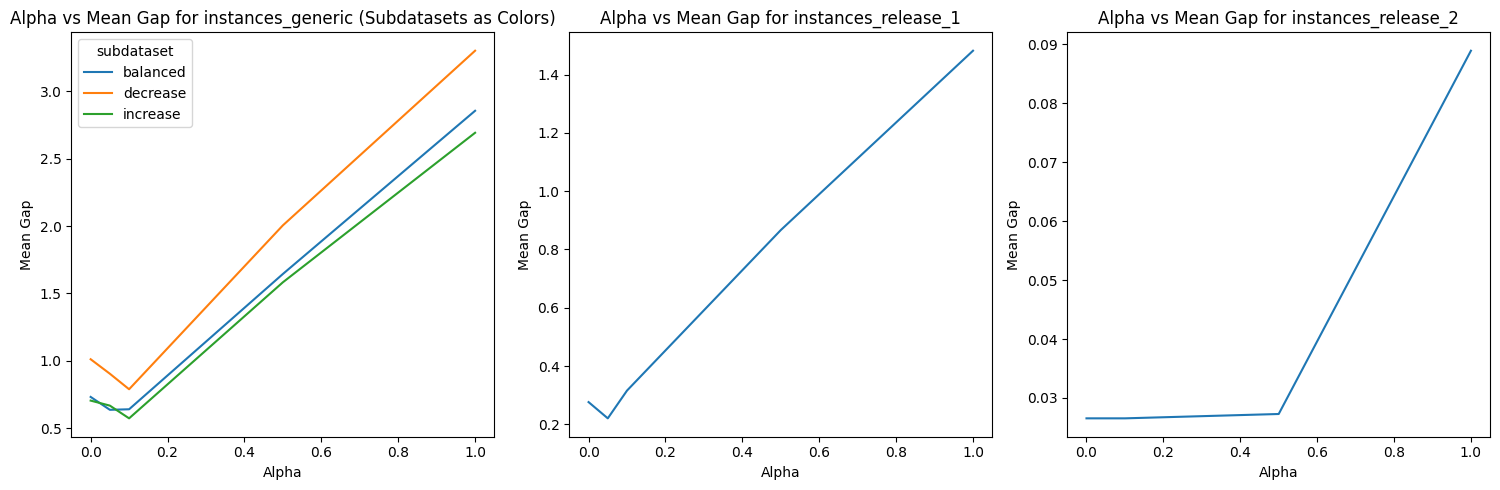

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = get_results()

results["success"] = results["cost_min"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Alpha plot for randomized_greedy
rg = results[results["method"] == "randomized_greedy"]

# Compute avg gap and std per dataset, subdataset, and alpha value
rg_avg_gap = rg.groupby(['dataset', 'subdataset', 'alpha'])['gap'].agg(['mean', 'std']).reset_index()

# Compute avg gap and std per dataset and alpha value
rg_dataset_avg_gap = rg.groupby(['dataset', 'alpha']).agg(
    avg_gap=('gap', 'mean'),
    std_gap=('gap', 'std'),
    avg_success=('success', 'mean')
).reset_index()
display(rg_dataset_avg_gap)

# Separate plots for generic and release datasets
datasets = rg['dataset'].unique()

fig, axes = plt.subplots(1, len(datasets), figsize=(5 * len(datasets), 5), sharey=False)

for ax, dataset in zip(axes, datasets):
    dataset_data = rg_avg_gap[rg_avg_gap['dataset'] == dataset]
    
    if dataset == 'instances_generic':
        # Plot each subdataset in a different color for generic
        sns.lineplot(x="alpha", y="mean", data=dataset_data, hue="subdataset", ax=ax)
        ax.set_title(f"Alpha vs Mean Gap for {dataset} (Subdatasets as Colors)")
    else:
        # Single color for release datasets
        sns.lineplot(x="alpha", y="mean", data=dataset_data, ax=ax)
        ax.set_title(f"Alpha vs Mean Gap for {dataset}")
    
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Mean Gap")

plt.tight_layout()
plt.show()


### Alpha plot for mip construction alpha and beta plot for mip construction beta


Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


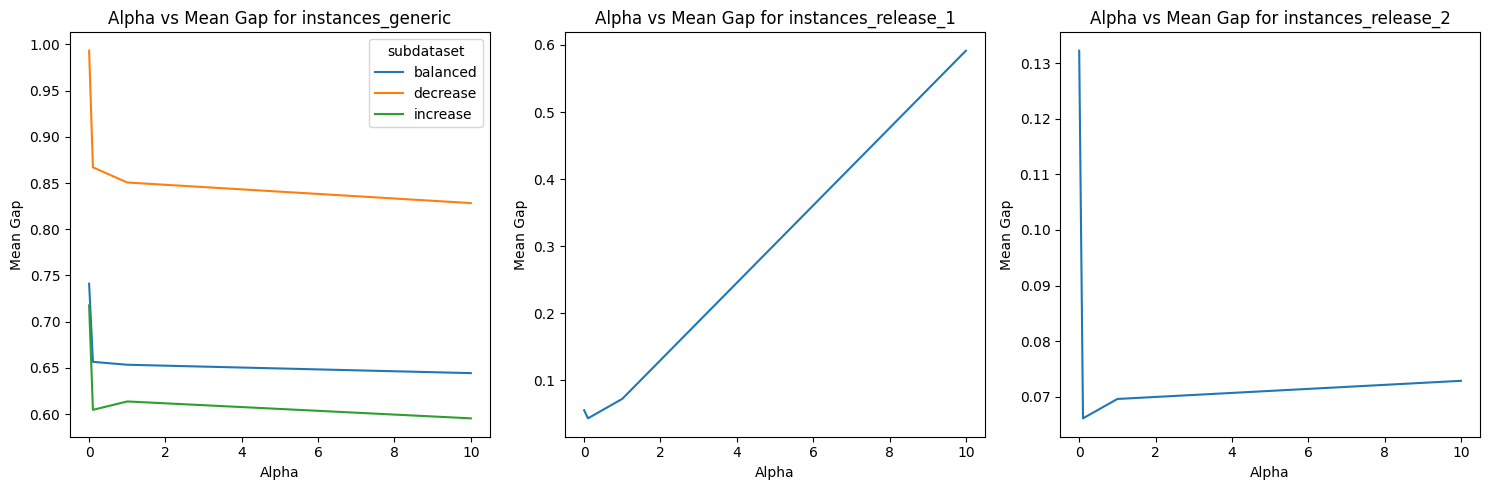

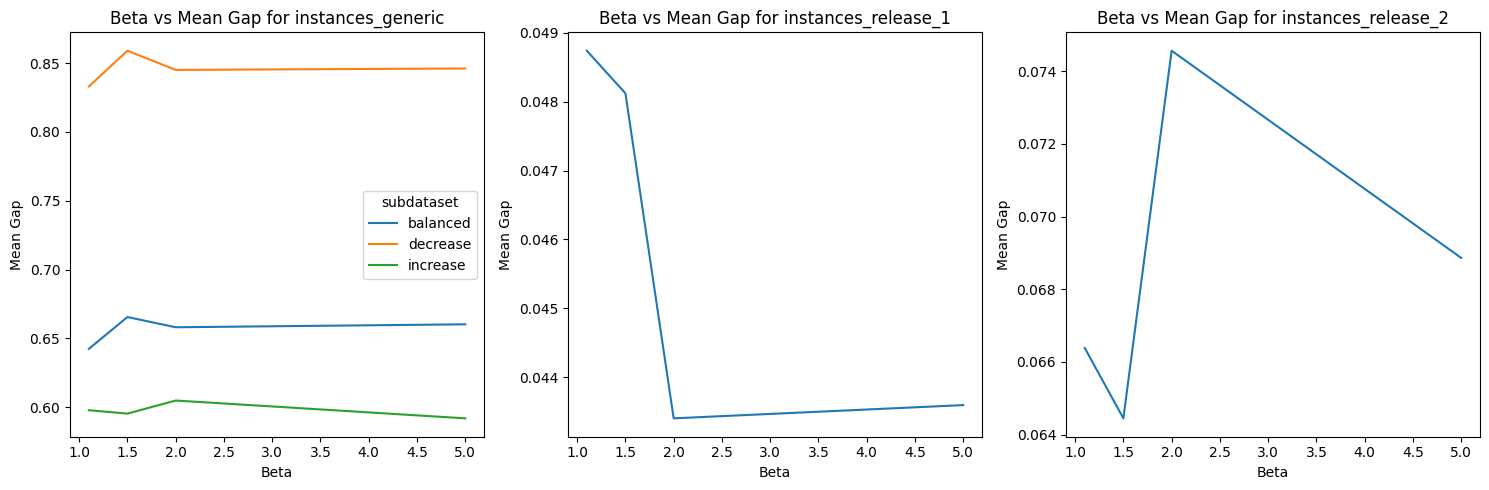

In [135]:
# mip construction alpha and beta plot for mip construction beta

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = get_results()

results["success"] = results["gap"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

def plot_alpha_beta(mip_avg_gap: np.ndarray, param: str, title: str) -> None:
    """
    Plots the mean gap against the given parameter (alpha or beta) for each dataset.

    :param mip_avg_gap: The aggregated gap data.
    :param param: The parameter to plot against ('alpha' or 'beta').
    :param title: The title for the plot.
    """
    unique_datasets = mip_avg_gap['dataset'].unique()
    num_datasets = len(unique_datasets)
    
    if num_datasets == 0:
        print(f"No datasets available for {title}.")
        return
    
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharey=False)
    
    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot
    
    for ax, dataset in zip(axes, unique_datasets):
        dataset_data = mip_avg_gap[mip_avg_gap['dataset'] == dataset]
        if len(dataset_data['subdataset'].unique()) > 1:
            sns.lineplot(x=param, y="mean", data=dataset_data, hue="subdataset", ax=ax)
        else:
            sns.lineplot(x=param, y="mean", data=dataset_data, ax=ax)
        ax.set_title(f"{param.capitalize()} vs Mean Gap for {dataset}")
        ax.set_xlabel(param.capitalize())
        ax.set_ylabel("Mean Gap")
    
    plt.tight_layout()
    plt.show()

# Alpha plot for mip construction alpha
mip_alpha = results[results["method"] == "mip_randomized_construction_random_alpha"]
mip_alpha_avg_gap = mip_alpha.groupby(['dataset', 'subdataset', 'alpha'])['gap'].agg(['mean', 'std']).reset_index()
plot_alpha_beta(mip_alpha_avg_gap, 'alpha', 'Alpha Plot for MIP Construction Alpha')

# Beta plot for mip construction beta
mip_beta = results[results["method"] == "mip_randomized_construction_random_beta"]
mip_beta_avg_gap = mip_beta.groupby(['dataset', 'subdataset', 'beta'])['gap'].agg(['mean', 'std']).reset_index()
plot_alpha_beta(mip_beta_avg_gap, 'beta', 'Beta Plot for MIP Construction Beta')

### Alpha-beta plot for mip construction bias

Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists


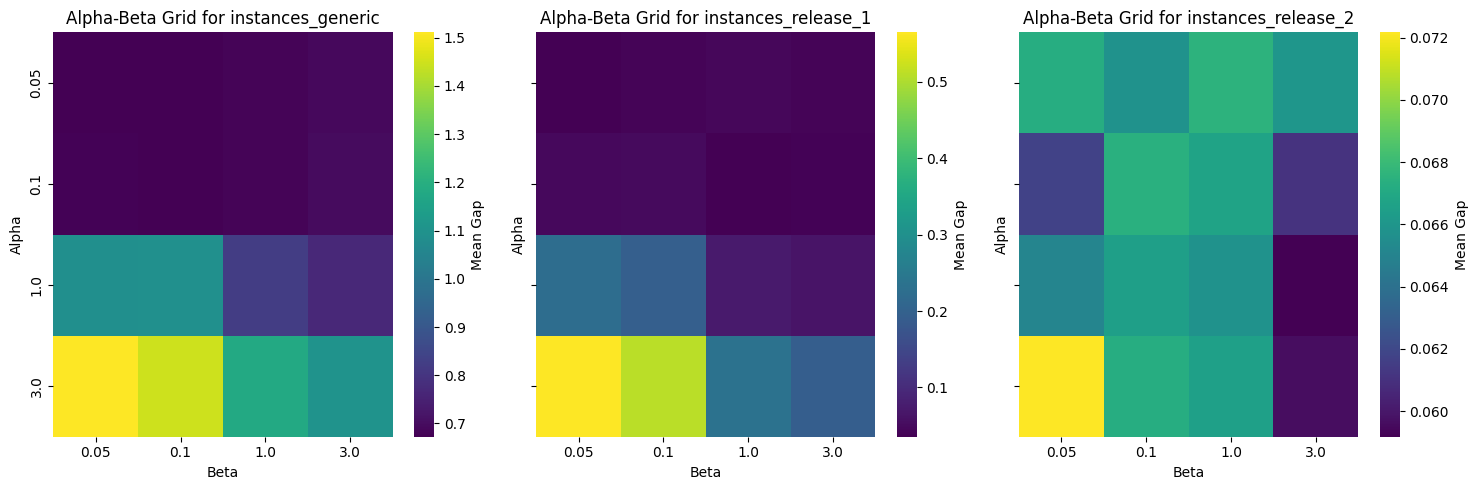

In [142]:
# mip construction alpha and beta plot for mip construction bias

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = get_results()

# Ensure success column is correctly set
results["success"] = results["gap"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter results for the specific method
filtered_results = results[results["method"] == "mip_randomized_construction_bias"]

# Group by dataset, subdataset, alpha, and beta to calculate mean gap
bias_avg_gap = filtered_results.groupby(['dataset', 'subdataset', 'alpha', 'beta'])['gap'].mean().reset_index()

def plot_alpha_beta_grid(bias_avg_gap: pd.DataFrame) -> None:
    """
    Plots a 2D grid of alpha vs beta with mean gap as the color intensity for each dataset.

    :param bias_avg_gap: The aggregated gap data with alpha and beta.
    """
    unique_datasets = bias_avg_gap['dataset'].unique()
    num_datasets = len(unique_datasets)
    
    if num_datasets == 0:
        print("No datasets available for plotting.")
        return
    
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharey=True)
    
    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot
    
    for ax, dataset in zip(axes, unique_datasets):
        dataset_data = bias_avg_gap[bias_avg_gap['dataset'] == dataset]
        # Use pivot_table with aggregation to handle duplicates
        pivot_table = dataset_data.pivot_table(index="alpha", columns="beta", values="gap", aggfunc='mean')
        # Sort the pivot table by alpha to ensure natural increasing order
        pivot_table.sort_index(ascending=True, inplace=True)
        sns.heatmap(pivot_table, ax=ax, cmap="viridis", cbar_kws={'label': 'Mean Gap'})
        ax.set_title(f"Alpha-Beta Grid for {dataset}")
        ax.set_xlabel("Beta")
        ax.set_ylabel("Alpha")
    
    plt.tight_layout()
    plt.show()

# Plot the alpha-beta grid
plot_alpha_beta_grid(bias_avg_gap)


### Now we want to choose the best setting for each method, one choice per dataset

In [144]:
alpha_randomized_greedy = 0.05
alpha_mip_randomized_construction_bias = 0.05
beta_mip_randomized_construction_bias = 3

alpha_mip_randomized_construction_random_alpha = 0.1
beta_mip_randomized_construction_random_beta = 3

def filter_results_by_method(results: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the results DataFrame based on specific method criteria.

    :param results: The DataFrame containing the results to filter.
    :return: A filtered DataFrame.
    """
    def apply_filter(row: pd.Series) -> bool:
        if row["method"] == "randomized_greedy":
            return row["alpha"] == alpha_randomized_greedy
        if row["method"] == "mip_randomized_construction_bias":
            return (row["alpha"] == alpha_mip_randomized_construction_bias) and (row["beta"] == beta_mip_randomized_construction_bias)
        elif row["method"] == "mip_randomized_construction_random_alpha":
            return row["alpha"] == alpha_mip_randomized_construction_random_alpha
        elif row["method"] == "mip_randomized_construction_random_beta":
            return row["beta"] == beta_mip_randomized_construction_random_beta
        return True

    return results[results.apply(apply_filter, axis=1)]

results = get_results()

before = len(results)
results = filter_results_by_method(results)
after = len(results)
print(f"Filtered {before - after} rows")

# Ensure success column is correctly set
results["success"] = results["gap"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Correct the groupby to use a list for multiple columns
aggregated_results = results.groupby(['dataset', 'method']).agg(
    mean_gap=('gap', 'mean'),
    std_gap=('gap', 'std'),
    success_rate=('success', 'mean')
).reset_index()

rename_dataset = {
    "instances_generic": "RG",
    "instances_release_1": "C1",
    "instances_release_2": "C2"
}

aggregated_results["dataset"] = aggregated_results["dataset"].map(rename_dataset)

# Pivot the DataFrame to have 'method' as rows, 'dataset' as columns, and 'mean_gap', 'std_gap' as subcolumns
aggregated_results = aggregated_results.pivot_table(
    index='method',
    columns='dataset',
    values=['mean_gap', 'std_gap', 'success_rate']
)

# display the table
display(aggregated_results)


Dataset construction_heuristics.csv already exists
Dataset construction_heuristics_agg.csv already exists
Filtered 6110 rows


mean_gap                      \
dataset                                         C1        C2        RG   
method                                                                   
gurobi                                         NaN       NaN  0.850512   
mip_randomized_construction_bias          0.039959  0.066022  0.690934   
mip_randomized_construction_random_alpha  0.043420  0.066070  0.709392   
randomized_greedy                         0.220871  0.026533  0.735720   
simple_randomized                         1.636293       NaN  2.963843   

                                           std_gap                      \
dataset                                         C1        C2        RG   
method                                                                   
gurobi                                         NaN       NaN  1.925081   
mip_randomized_construction_bias          0.025008  0.018305  0.755102   
mip_randomized_construction_random_alpha  0.032499  0.022085  0.758142   
randomized_greedy                         0.163817       NaN  0.661616   
simple_randomized                         1.284843       NaN  2.360420   

                                         success_rate                 
dataset                                            C1        C2   RG  
method                                                                
gurobi                                            NaN       NaN  1.0  
mip_randomized_construction_bias             1.000000  1.000000  1.0  
mip_randomized_construction_random_alpha     1.000000  1.000000  1.0  
randomized_greedy                            0.857143  0.029412  1.0  
simple_randomized                            0.952381  0.000000  1.0